In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

## Table of Contents
- [Timeseries Comparison](#comparison)
- [GLM](#weightings)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

We have choices to either compute correlation between subjects and aggregated emotions or group level and aggregated emotions. We as well introduce other movies for the same subject in order to do permutation testing.

In [2]:
# 1. Loading Gradient Example
networks = list(index2region.keys())
moviename = 'Sintel'
# opt1: Loading Individual Gradient 
# tmp = load('./resources/dynamic_grad/individual_level/Chatter_grad.pkl')
# G_movie, varM = tmp['S30']

# opt2: Loading Group Gradient
G_movie, varM = load('./resources/dynamic_grad/group_level2/{}_40_grad.pkl'.format(moviename))

# 2. Loading Matching Emotion Track
full_df  = pd.read_csv('./data/emoFiles/emotion_compile.csv')
emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

We use the following 4 metrics:
- network variance/position
- network volume
- intra-network distances
- explained variance from eigendecomposition

Text(0.5, 0.98, 'Metrics evaluations')

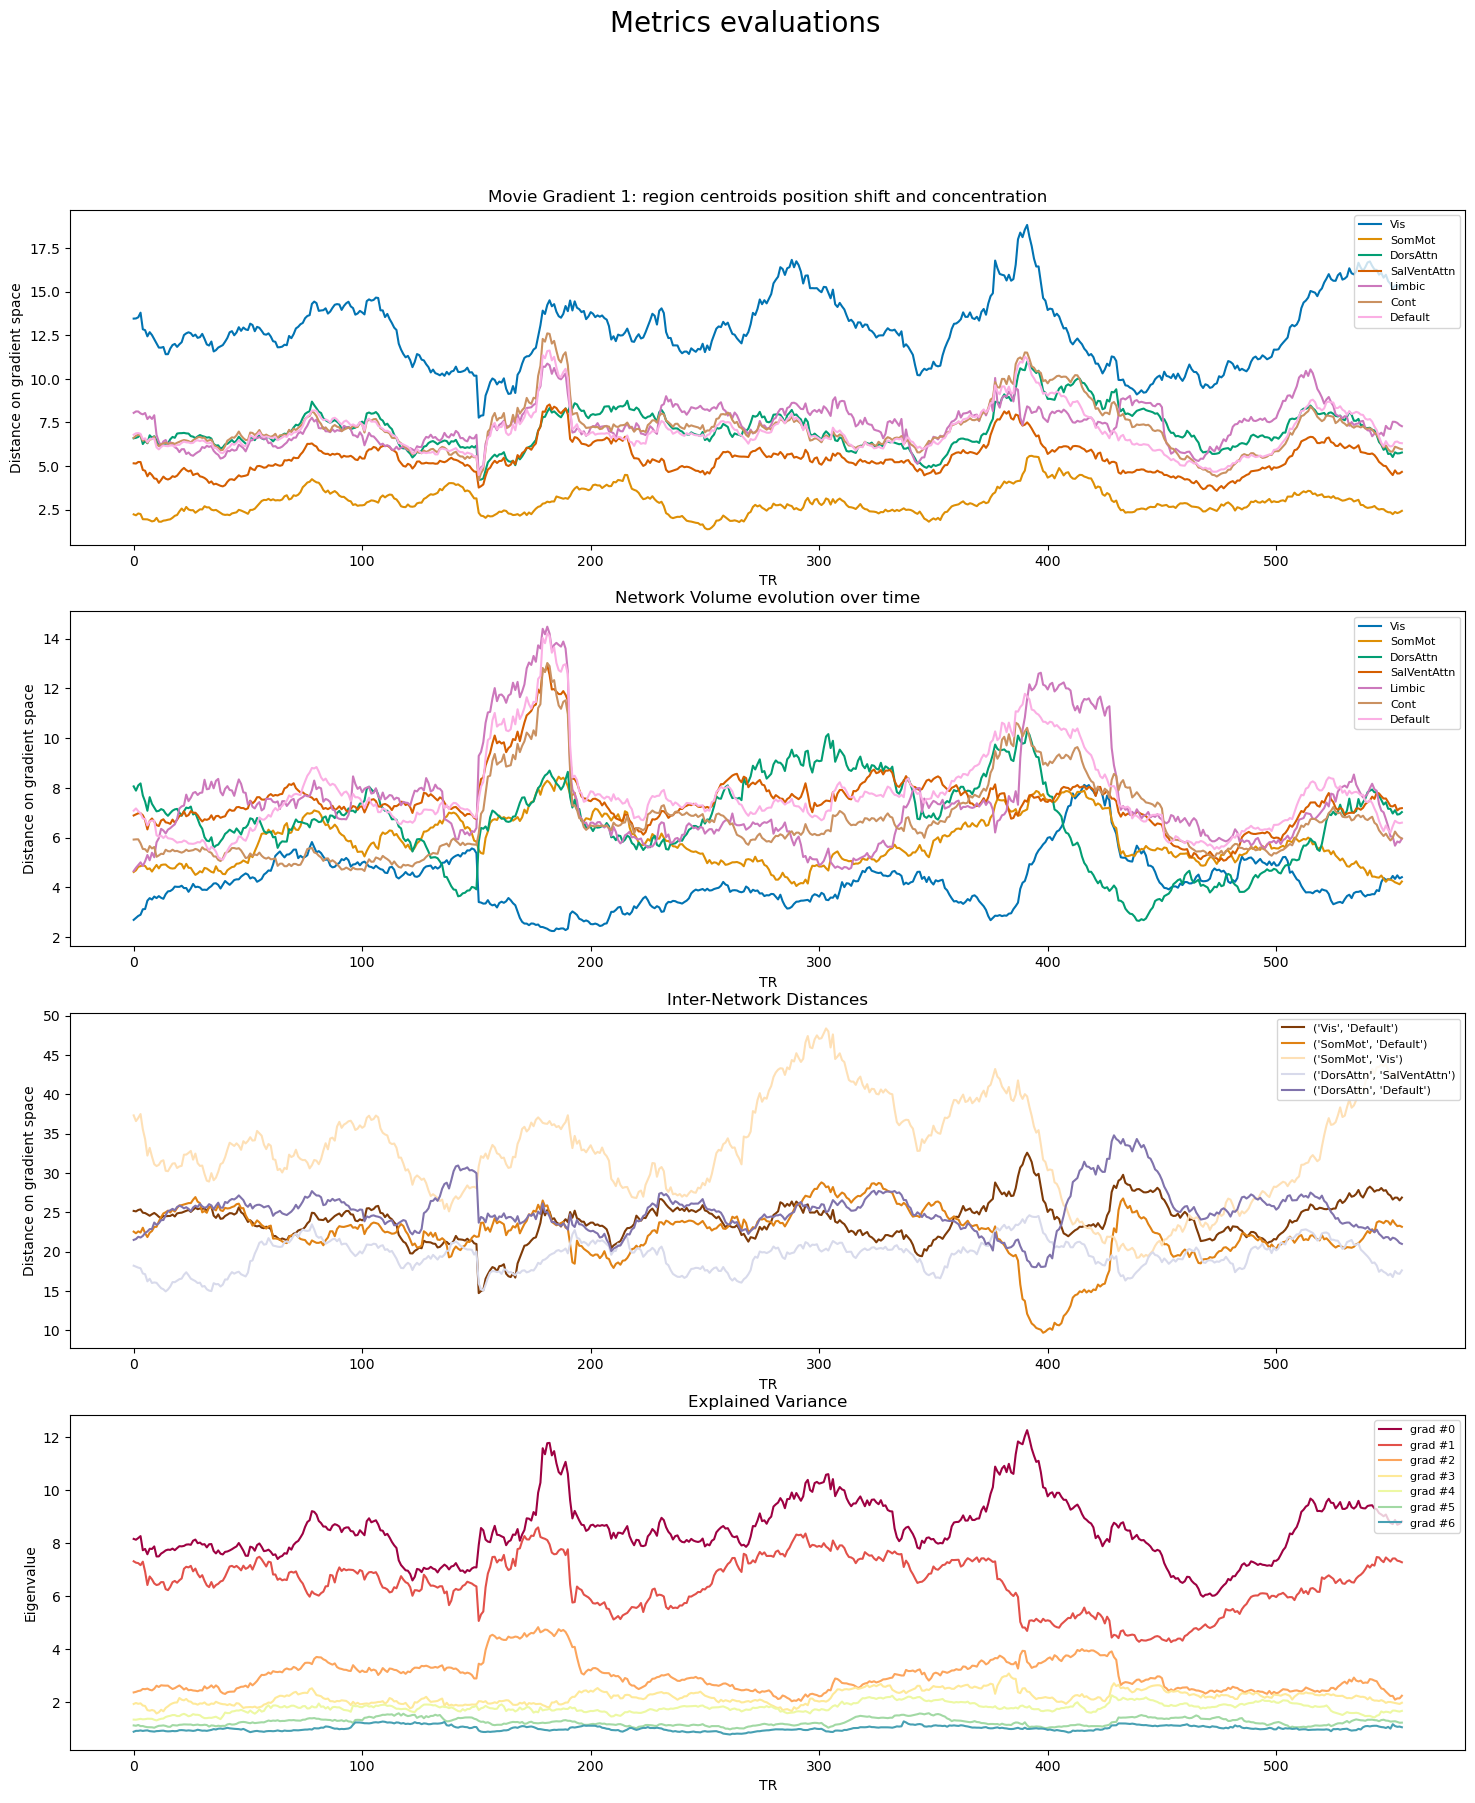

In [3]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)

fig, ax = plt.subplots(4,1,figsize=(18,20))

# METRIC 1
nb = len(networks)
grad_idx = 0
for idx, R in enumerate(networks):
    y = network_position(G_movie, R, grad_idx)
    x = np.arange(len(y))
    error = network_variance(G_movie, R, grad_idx)
    ax[0].plot(x,y, label=R, color=my_cmap.colors[idx])

    # ax[0].fill_between(x, y-error, y+error, alpha=0.4)
    ax[0].legend(loc=1, prop={'size':8})
    ax[0].set_xlabel('TR')
    ax[0].set_ylabel('Distance on gradient space')
# ax[0].axvline(x=wash, label='after wash')
ax[0].set_title("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

# METRIC 2
nb = len(networks)
for idx, R in enumerate(networks):
    y = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))

    ax[1].plot(x,y, label=R, color=my_cmap.colors[idx])
    ax[1].legend(loc=1, prop={'size':8})    
    ax[1].set_xlabel('TR')
    ax[1].set_ylabel('Distance on gradient space')
ax[1].set_title("Network Volume evolution over time")

# METRIC 3
pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default")]
nb = len(pairs)
cm = plt.get_cmap('PuOr')
ax[2].set_prop_cycle(color=[cm(1.*i/nb) for i in range(nb)])
for idx, pair in enumerate(pairs):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))
    ax[2].plot(x,y, label=pair)
    ax[2].legend(loc=1, prop={'size':8}) 
    ax[2].set_xlabel('TR')
    ax[2].set_ylabel('Distance on gradient space')
ax[2].set_title("Inter-Network Distances")   

# METRIC 4
nb = varM.shape[1]-3
cm = plt.get_cmap('Spectral')
ax[3].set_prop_cycle(color=[cm(1.*i/nb) for i in range(nb)])
for idx, gradnb in enumerate(range(varM.shape[1]-3)):
    y = varM[:,gradnb]
    x = np.arange(len(y))
    ax[3].plot(x,y, label='grad #{}'.format(gradnb))
    ax[3].legend(loc=1, prop={'size':8}) 
    ax[3].set_xlabel('TR')
    ax[3].set_ylabel('Eigenvalue')
ax[3].set_title("Explained Variance") 

plt.suptitle("Metrics evaluations".format(grad_idx + 1), size=20)

Text(0.5, 1.0, 'Aggregated Emotion time series')

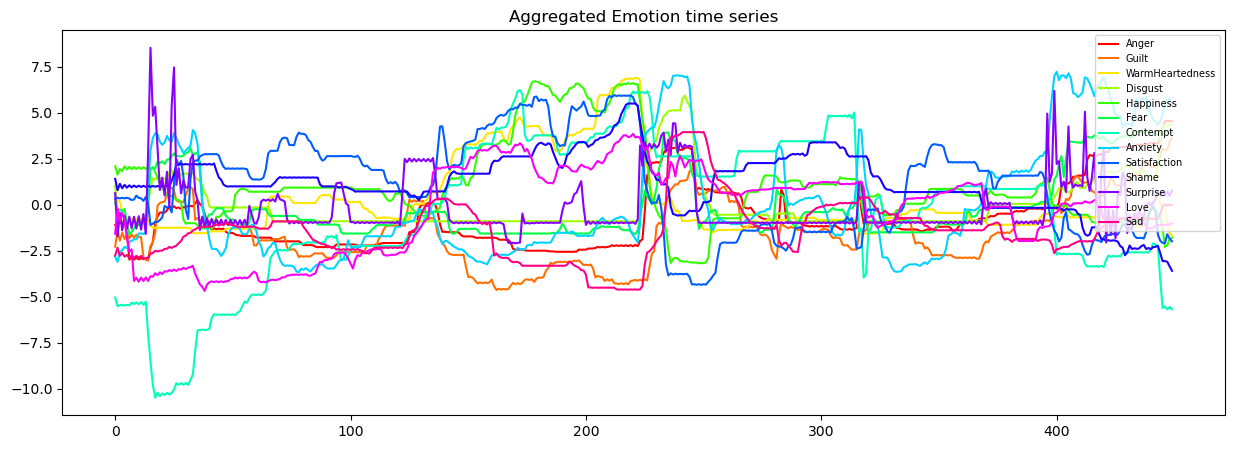

In [4]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

NUM_COLORS = len(select)
cm     = plt.get_cmap('hsv')
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    ax.plot(emo_series, label=emotion)

ax.legend(loc=1, prop={'size':7})
ax.set_title("Aggregated Emotion time series")

Compute correlation between a given metric and emotion series

In [5]:
# Grid for each network of correlation with emotions
grad_idx = 0
smfactor = 1
tolshift = 0


n = len(networks)
m = len(select)

pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default")]
nb_metric = 4
scores  = np.zeros((nb_metric, n,m))
nscores = np.zeros((nb_metric, n,m))

# METRIC 1
for idx, pair in enumerate(tqdm(pairs)):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)
    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[0, idx,jdx] = nscore
        scores[0, idx,jdx]  = corr           

# METRIC 2
for idx, R in enumerate(networks):
    y  = network_variance(G_movie, R, grad_idx)
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[1, idx,jdx] = nscore
        scores[1, idx,jdx]  = corr        
    
# METRIC 3
for idx, R in enumerate(networks):
    y  = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[2, idx,jdx] = nscore
        scores[2, idx,jdx]  = corr

# METRIC 4
for idx, R in enumerate(networks):
    y  = varM[:,idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[3, idx,jdx] = nscore
        scores[3, idx,jdx]  = corr


100%|██████████| 7/7 [03:07<00:00, 26.80s/it]


In [14]:
# PREPARING REGRESSORS
luminance = np.loadtxt('./resources/llf-features_extracted/SintelLuminance.txt', delimiter=',')
audio     = np.loadtxt('./resources/llf-features_extracted/SintelAudio.txt', delimiter=',')
diffenerg = np.loadtxt('./resources/llf-features_extracted/SinteldiffNrg.txt', delimiter=',')

k = G_movie.shape[0] - 1
# downsample to rate for window rate
luminance = zscore(local_average(luminance, ks=31)[:k])
audio     = zscore(local_average(audio[:,0], ks=52)[:k])
diffenerg = zscore(local_average(diffenerg, ks=31)[:k])
llf = [luminance, audio, diffenerg]

In [15]:
# METRIC 5 -> which is the luminance audio and diff energy values that we want to potentially find correlation with
nextra = np.zeros((n,m))
extra  = np.zeros((n,m))
for idx, R in enumerate(tqdm(networks)):
    if idx >= 3: 
        continue
    y = llf[idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nextra[idx,jdx] = nscore
        extra[idx,jdx]  = corr

100%|██████████| 7/7 [01:19<00:00, 11.38s/it]


In [19]:
# nscores = np.concatenate([nscores,nextra[None]])
# scores = np.concatenate([scores,extra[None]])

In [5]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores2[idx,jdx] = corr

100%|██████████| 400/400 [00:09<00:00, 43.08it/s]


#### Correlation brain maps with 7 networks
We select here the max and visualize how well they correlate each other

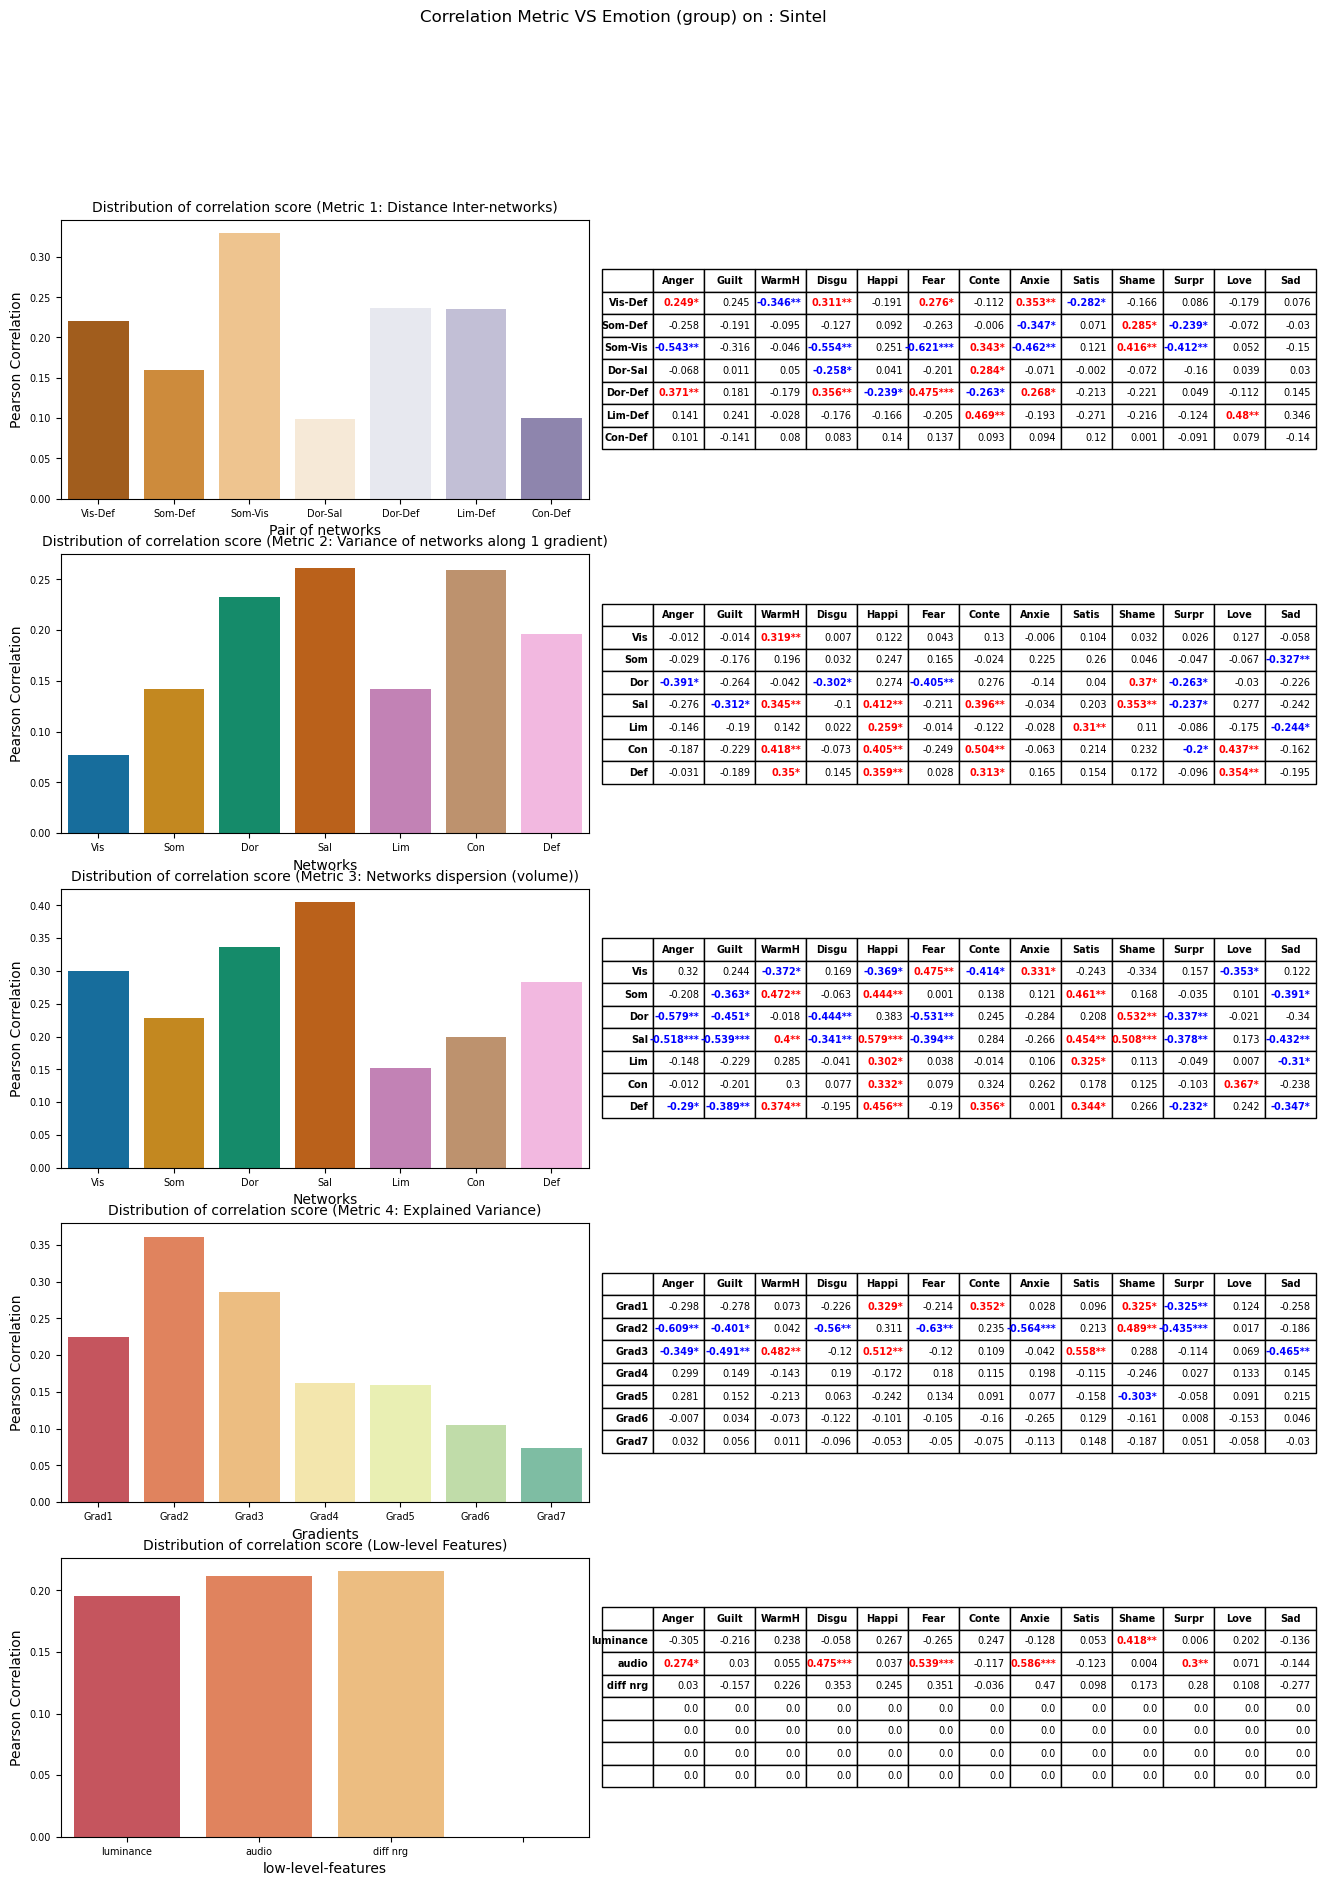

In [20]:
from matplotlib.font_manager import FontProperties

xlabels = ["Pair of networks", "Networks", "Networks", "Gradients", "low-level-features"]
titles  = ["Distribution of correlation score (Metric 1: Distance Inter-networks)",
            "Distribution of correlation score (Metric 2: Variance of networks along 1 gradient)",
            "Distribution of correlation score (Metric 3: Networks dispersion (volume))",
            "Distribution of correlation score (Metric 4: Explained Variance)",
            "Distribution of correlation score (Low-level Features)"]

nb_metric = 5
PALETTES = ['PuOr', 'colorblind', 'colorblind', 'Spectral', 'Spectral']
fig,ax = plt.subplots(nb_metric ,2,figsize=(15,21))
for m in range(nb_metric):
    pal = sns.color_palette(PALETTES[m], 8)
    # MAKING TABLE
    tabling = np.empty((7,14), dtype=np.object_)
    for j in range(14):
        for i in range(7):
            if j == 0:
                if m == 0:
                    p1,p2 = pairs[i] 
                    tabling[i,j] = p1[:3] + '-' + p2[:3]
                elif m == 3:
                    tabling[i,j] = 'Grad{}'.format(i+1)
                elif m == 4:
                    if i >= 3:
                        tabling[i,j] = " "
                    else:    
                        tabling[i,j] = ["luminance", "audio", "diff nrg"][i]
                else:
                    tabling[i,j] = networks[i][:3]
            else:
                tabling[i,j] = np.object_(np.round(scores[m][i,j-1],3))

    concat_region = np.concatenate([[r] * scores[m].shape[1] for r in tabling[:,0]])
    corr_score = {'networks': concat_region, 'mean-corr': np.abs(scores[m].flatten())}

    sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, palette=pal, errorbar=None)
    # sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
    # sns.swarmplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, color="r", alpha=.65)
    ax[m,0].set_title(titles[m], size=10)
    ax[m,0].tick_params(labelsize=7)
    ax[m,0].set_xlabel(xlabels[m], size=10)
    ax[m,0].set_ylabel('Pearson Correlation', size=10)

    ax[m,1].axis('tight')
    ax[m,1].axis('off')

    table = ax[m,1].table(cellText=tabling,
                            colLabels=[''] + [s[:5] for s in select],
                            loc='center')

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        if (col == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            
        # stress on which value is significant against null distribution
        nscore  = nscores[m, row-1, col - 1]
        nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)
        
        if row != 0 and col !=0 :
            if m==4 and row >= 3 : continue
            cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)
            
            if nbstars > 0:
                cell.set_text_props(fontproperties=FontProperties(weight='bold'))
                if tabling[row-1,col] > 0:
                    cell.get_text().set_color('red')
                else:
                    cell.get_text().set_color('blue')


    
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.35, 1.35)  # may help                        

plt.suptitle("Correlation Metric VS Emotion (group) on : {}".format(moviename))
plt.show()

Example of null distribution: special sample (i.e we check the correlation of metrics and completely different movies)

In [8]:
# Compute metrics
tmp_emo = 'Anxiety'
net     = 'Limbic'

y  = np.asarray([network_volume(G_movie[t], net) 
                    for t in range(len(G_movie))])

In [9]:
# Compute Correlation with different movies
cur_emo = other_df[other_df.item == tmp_emo]
z1 = zscore(y)
tmp_corr = []
for f in cur_emo.filename.unique():
    tmp = np.array(cur_emo[cur_emo.filename == f]['score'])
    z2  = zscore(tmp)
    if z1.shape[0] < z2.shape[0]:
        diff = z2.shape[0] - z1.shape[0]
        tocompare = np.pad(z1, diff)[diff:]
        tmp_corr.append(correlation_search(tocompare, z2, 0, False))
    else:
        m = min(z1.shape[0], z2.shape[0])
        tmp_corr.append(correlation_search(z1[:m], z2[:m], 0, False))

best_matchmovie = cur_emo.filename.unique()[np.argmax(tmp_corr)]

Text(0.5, 1.0, 'Metric vs other movie emotion series')

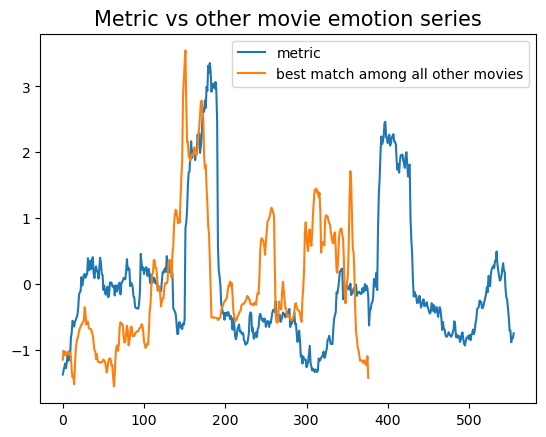

In [12]:
plt.plot(z1, label='metric')
plt.plot(zscore(np.array(cur_emo[cur_emo.filename == 'W_BigBuckBunny13.csv']['score'])), label='best match among all other movies')
plt.legend(prop={'size':10})
plt.title("Metric vs other movie emotion series", size=15)

For Metric 5: we monitor each parcels/regions separately 

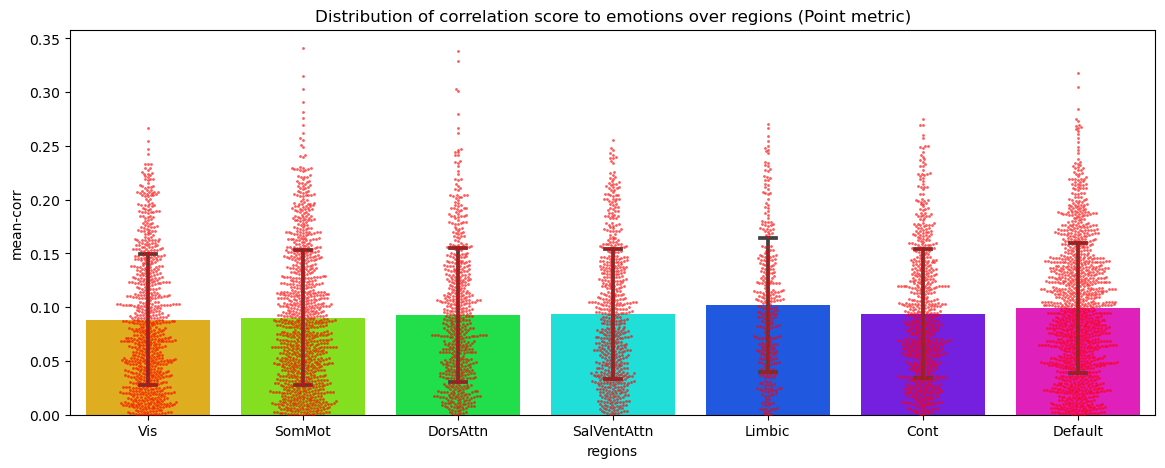

In [11]:
partial_region = load('./resources/region400yeo7.pkl')
partial_region = list(partial_region.values())

concat_region = np.concatenate([partial_region * scores2.shape[1]])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores2.flatten())}

pal = sns.color_palette('hsv', len(networks))
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd", palette=pal)
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="r", alpha=.65, size=2)
plt.title("Distribution of correlation score to emotions over regions (Point metric)")
plt.show()

Direct series visualization comparison (check)

In [13]:
indextosee = []
n = np.prod(scores.shape[1:]) - 1
for m in range(nb_metric):
    indextosee.append(list(scores[m].flatten().argsort()[[0,n-1,n]]))

indextosee = np.stack(indextosee)

Text(0.5, 0.98, 'Examples of correlations metric vs emotion')

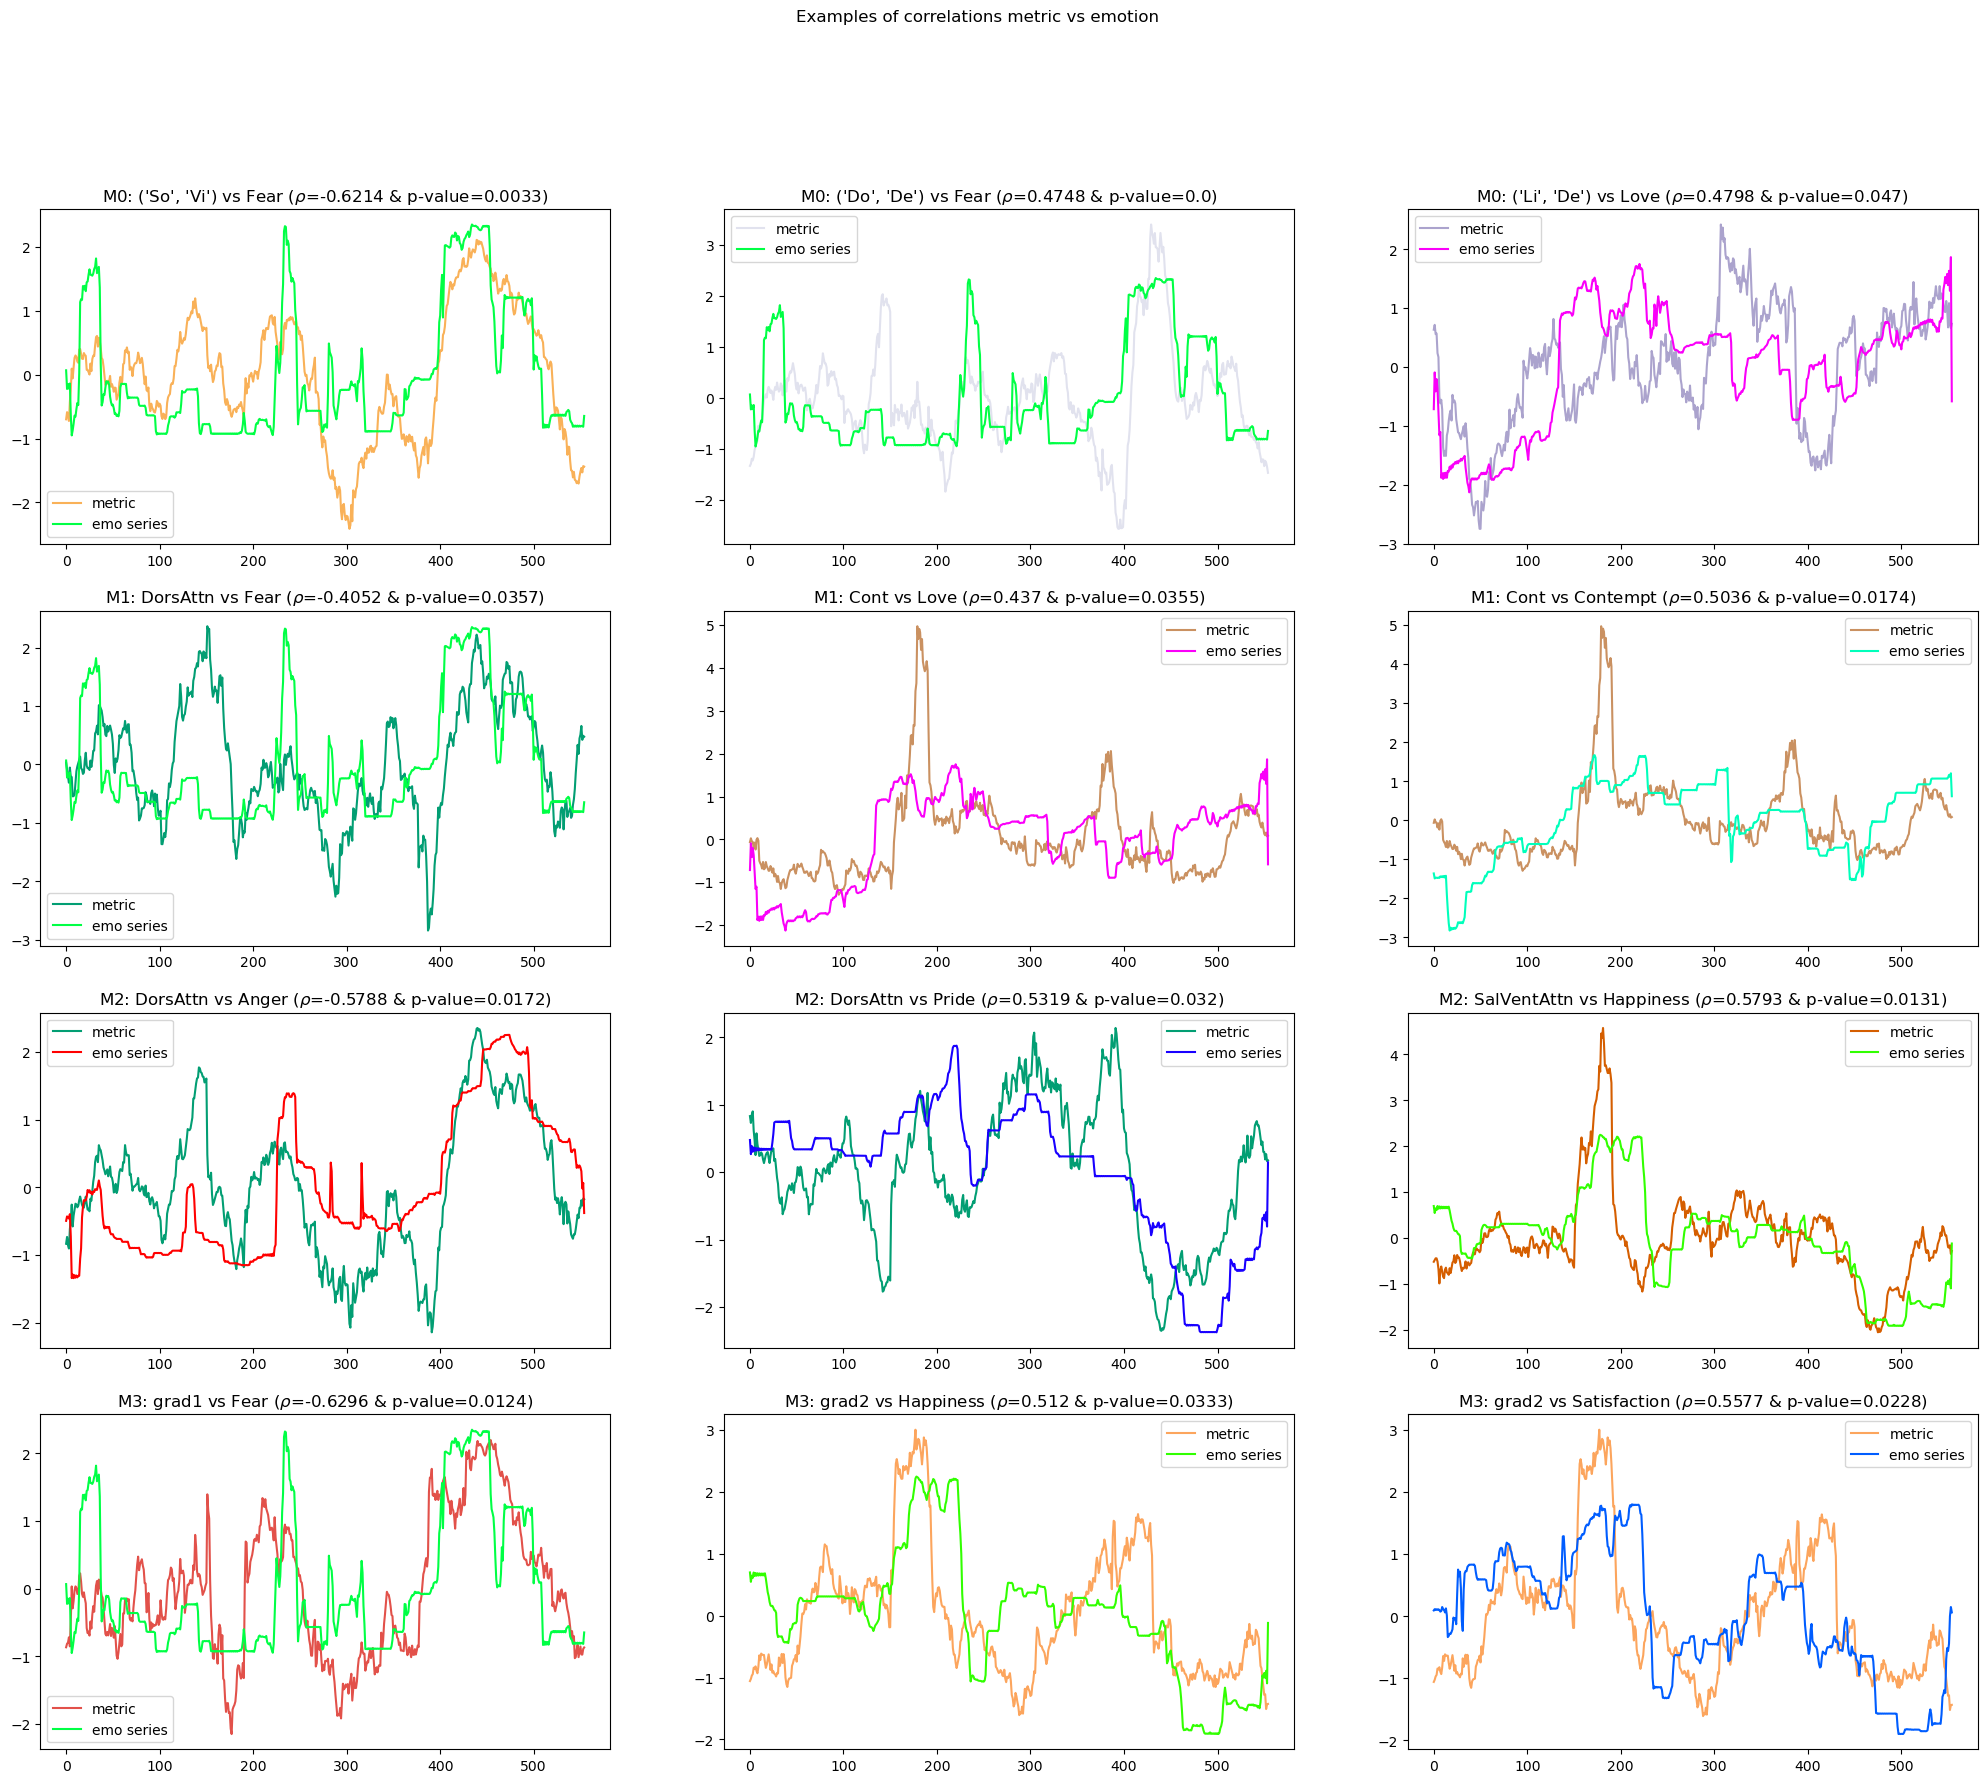

In [14]:
fig, ax = plt.subplots(4,3, figsize=(25,20))

# compute the index we want to see 
# (we take the 2 largest positive corr and 1 most negative corr for each metric)
indextosee = []
n = np.prod(scores.shape[1:]) - 1
for m in range(nb_metric):
    indextosee.append(list(scores[m].flatten().argsort()[[0,n-1,n]]))

indextosee = np.stack(indextosee)



pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
for m in range(nb_metric):
    
    if m in [1,2]:
        colors = my_cmap.colors
    else:
        cm     = plt.get_cmap(PALETTES[m])
        cmEmo     = plt.get_cmap('hsv')
        colors = [cm(1.*i/7) for i in range(7)]
        colorsEmo = [cmEmo(1.*i/13) for i in range(13)]
    for j in range(3):
        idx = indextosee[m][j]
        a,b = idx//13, idx%13
        if m == 0:
            p1,p2 = pairs[a]
            y  = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                            for t in range(len(G_movie))])
            label = p1[:2],p2[:2]                          
        elif m == 1:
            y  = network_variance(G_movie, networks[a], grad_idx)
            label = networks[a]
        elif m == 2:
            y  = np.asarray([network_volume(G_movie[t], networks[a])
                    for t in range(len(G_movie))])
            label = networks[a]
        else:
            y  = varM[:,a]
            label = "grad{}".format(a)
        
        z1 = zscore(y)
        # z1 = low_pass(z1, ks=40)
        emo_series = np.array(emo_df[emo_df.item==select[b]]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])
        z1   = z1[:z2.shape[0]]
        corr = correlation_search(z1,z2, 0, 1)[0]
        _, nscore, _ = moviemix_stat_test(z1, z2, concat_other)
        if corr < 0:
            ax[m,j].plot(-z1, label='metric', color=colors[a])
            ax[m,j].plot(z2, label='emo series', color=colorsEmo[b])
        else:
            ax[m,j].plot(z1, label='metric', color=colors[a])
            ax[m,j].plot(z2, label='emo series', color=colorsEmo[b])
            
        titleemo = "Pride" if select[b] == "Shame" else select[b]
        ax[m,j].set_title("M{}: {} vs {} ({}={} & p-value={})".format(m,label,titleemo,r"$\rho$",np.round(corr,4), np.round(nscore,4)))
        ax[m,j].legend()
plt.suptitle('Examples of correlations metric vs emotion')

In [35]:
emo_series = np.array(emo_df[emo_df.item==select[9]]['score'])
concat_other = np.array(other_df[other_df.item == select[9]]['score'])

In [57]:
y  = network_variance(G_movie, networks[2], grad_idx)
z1   = zscore(y)
z2   = zscore(emo_series[:516])

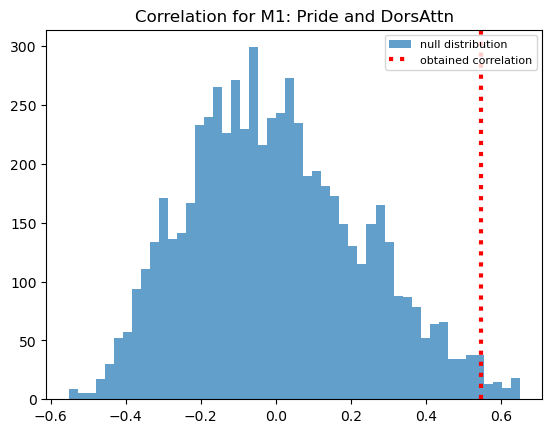

In [65]:
ndistrib,_,cur = moviemix_stat_test(z1, z2, concat_other)

plt.hist(ndistrib, bins=50, alpha=0.7, label="null distribution")
plt.axvline(x=cur, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
plt.title("Correlation for M1: Pride and DorsAttn")
plt.legend(loc=1, prop={'size':8})
plt.show()

In [ ]:
# # Uncomment for: Sanity Check of Eigenvector explained variances
# plot_eigenvector_importance(g_movie)
# plot_eigenvector_importance(g_rest)

#### Correlation brain maps with 400 parcellations

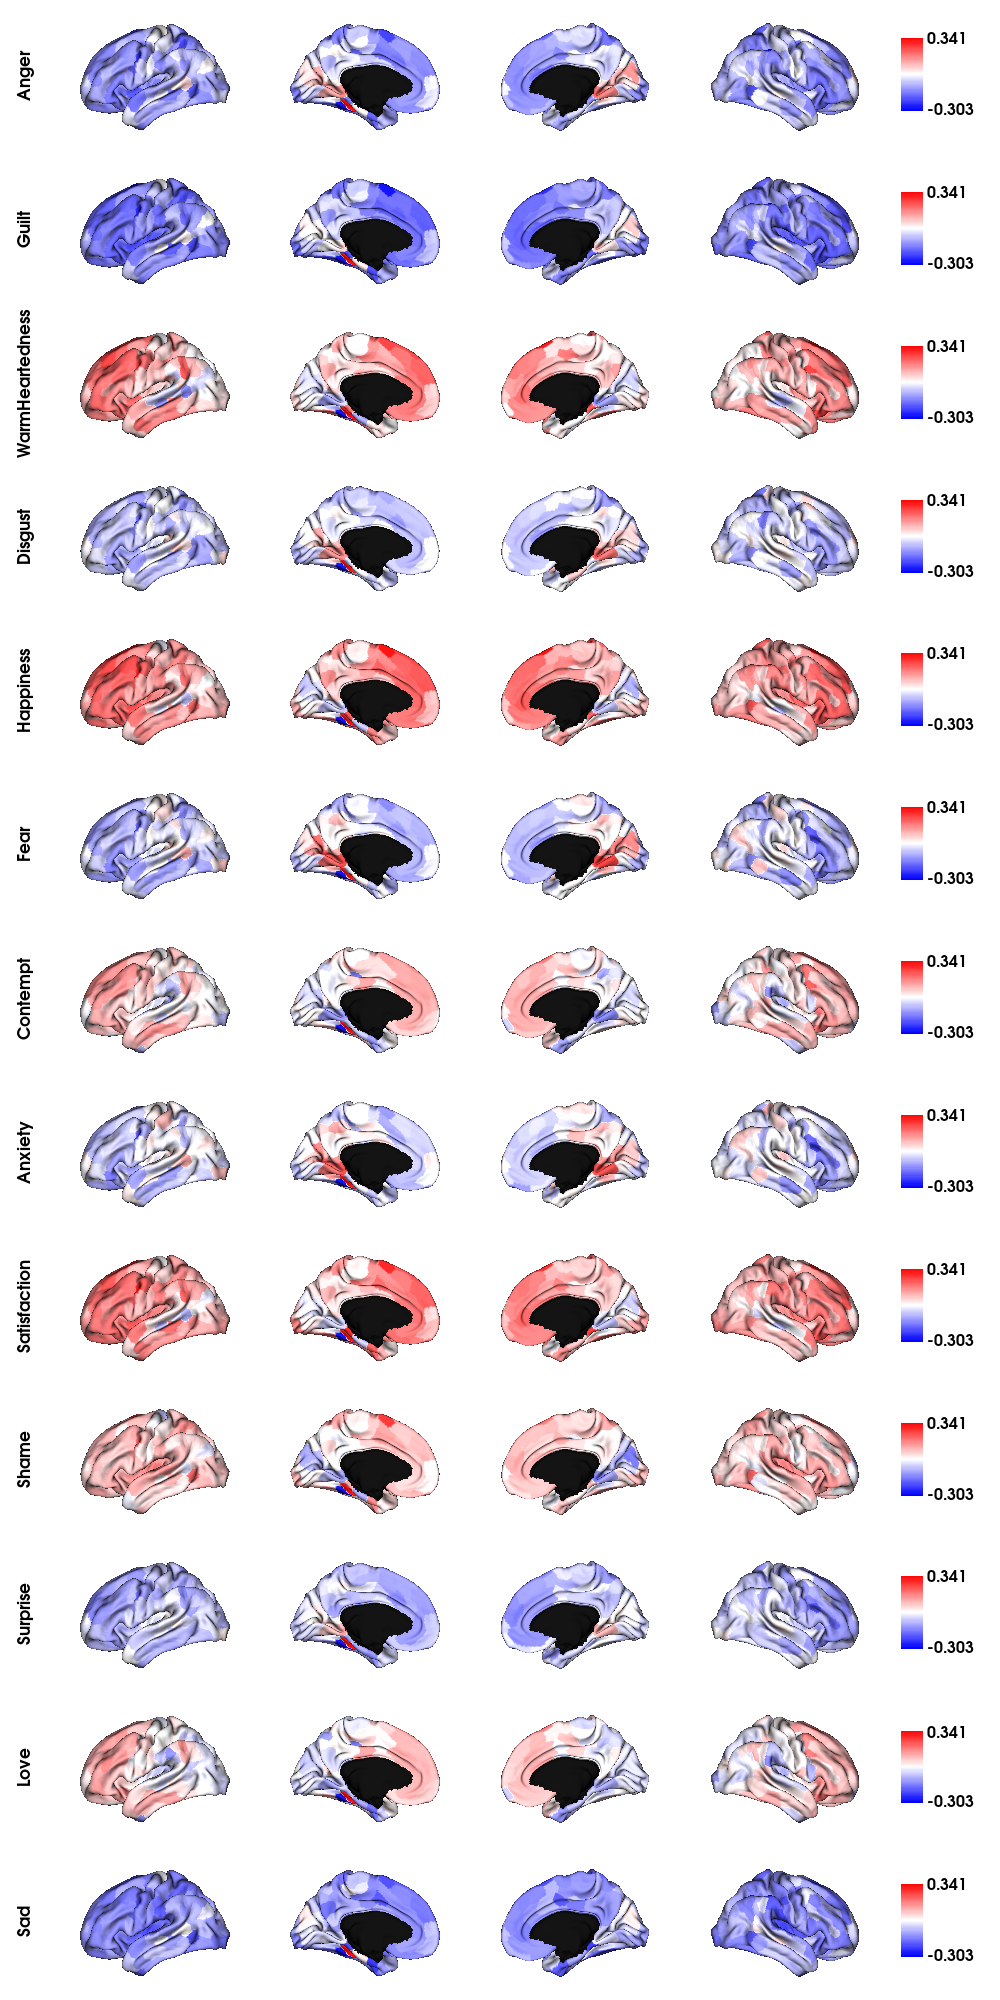

In [6]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = deepcopy(scores2.T)

grad = [None] * len(select)
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    gs[k][0]   = gs.min()
    gs[k][1]   = gs.max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='bwr',
                 color_bar=True, label_text=select, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


### GLM

In [21]:
n, _ , _ = G_movie.shape
# window reason we resize by -1
n = n - 1 

In [22]:
luminance = np.loadtxt('./resources/llf-features_extracted/SintelLuminance.txt', delimiter=',')
audio     = np.loadtxt('./resources/llf-features_extracted/SintelAudio.txt', delimiter=',')
diffenerg = np.loadtxt('./resources/llf-features_extracted/SinteldiffNrg.txt', delimiter=',')

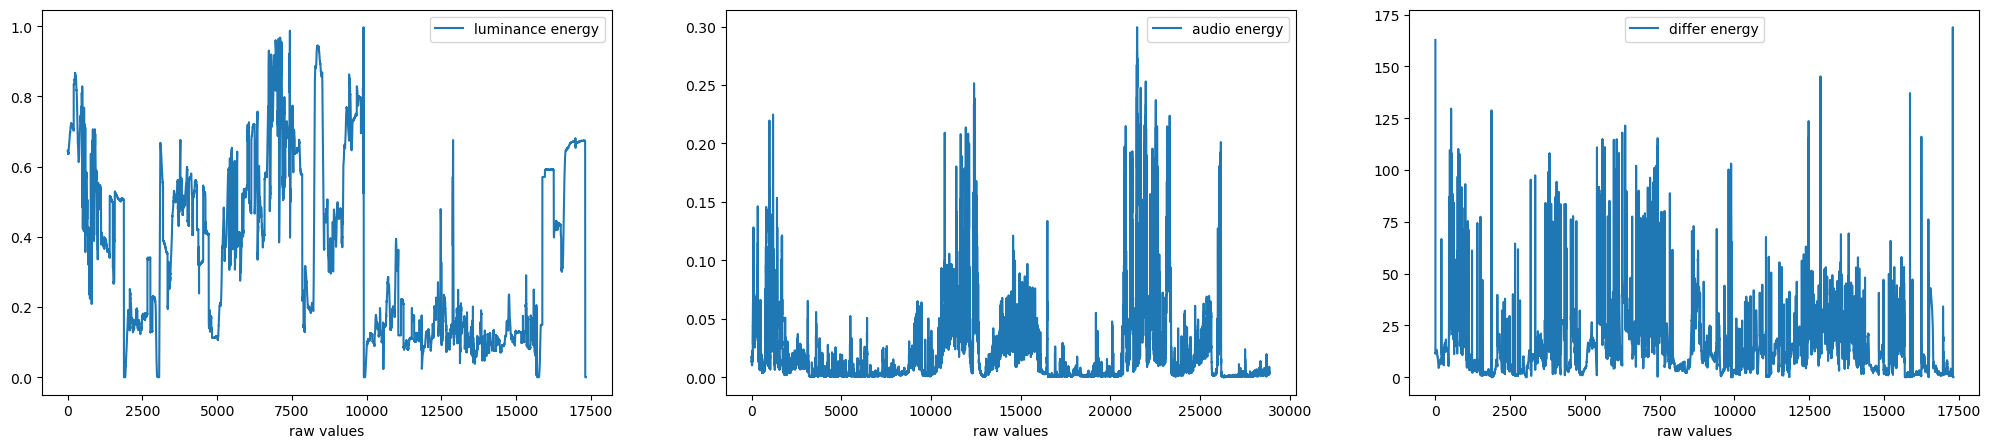

In [23]:
fig,ax = plt.subplots(1,3, figsize=(25,5))

ax[0].plot(luminance, label='luminance energy')
ax[1].plot(audio[:,0],label='audio energy')
ax[2].plot(diffenerg, label='differ energy')
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel('raw values')

In [24]:
def design_variance(X, which_predictor=1):
    ''' Returns the design variance of a predictor (or contrast) in X.
    
    Parameters
    ----------
    X : numpy array
        Array of shape (N, P)
    which_predictor : int or list/array
        The index of the predictor you want the design var from.
        Note that 0 refers to the intercept!
        Alternatively, "which_predictor" can be a contrast-vector
        (which will be discussed later this lab).
        
    Returns
    -------
    des_var : float
        Design variance of the specified predictor/contrast from X.
    '''
    
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

def local_average(signal,ks):
    size = len(signal)
    res  = np.zeros((size // ks+1))
    for idx,k in enumerate(range(0,len(signal), ks)):
        res[idx] = signal[k:k+ks].mean()
    return res


In [25]:
# PREPARING REGRESSORS
luminance = np.loadtxt('./resources/llf-features_extracted/SintelLuminance.txt', delimiter=',')
audio     = np.loadtxt('./resources/llf-features_extracted/SintelAudio.txt', delimiter=',')
diffenerg = np.loadtxt('./resources/llf-features_extracted/SinteldiffNrg.txt', delimiter=',')

# downsample to rate for window rate
luminance = zscore(local_average(luminance, ks=31)[:n])
audio     = zscore(local_average(audio[:,0], ks=52)[:n])
diffenerg = zscore(local_average(diffenerg, ks=31)[:n])

absemo_df = pd.read_csv('./data/emotion_compileBIDS.csv')
absemo_df = absemo_df[absemo_df['filename']=='W_{}13.csv'.format(moviename)]

regressors = [np.ones(n)]
smfactor = 1
abs_val = []
for b in range(len(select)):
    emotion = select[b]
    if select[b] == 'Shame':
        emotion2 = 'Pride'
    elif select[b] == 'Contempt':
        emotion2 = 'Regard'
    else:
        emotion2 = select[b]
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])

    absemo_series = np.array(absemo_df[absemo_df.item==emotion2]['score'])
    abs_val.append(absemo_series)
    smoothened = overlap_add(emo_series, smfactor)
    z2         = zscore(smoothened[:n])
    regressors.append(z2)

# add regressors for low-level features    
regressors.append(luminance)
regressors.append(audio)
regressors.append(diffenerg)
regressors = np.stack(regressors)
abs_val = np.asarray(abs_val)

In [26]:
# Obtain ratio of emotion timeseries
# ratio1 = np.abs(abs_val).mean(axis=1) / np.abs(abs_val).mean(axis=1).sum()

glmnet = {}

for i in range(len(networks)):
    # Computing to fit series
    y  = np.asarray([network_volume(G_movie[t], networks[i])
                for t in range(len(G_movie))])
    label = networks[0]
    y = zscore(y)[:-1]

    # regress solving
    X = regressors.T

    beta = (np.linalg.inv(np.matmul(X.T, X)) @ X.T) @ y

    y_hat_meter = X @ beta

    N = y.size
    P = X.shape[1]
    df = (N - P)
    
    sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
    design_variance_weight = design_variance(X, 1)
    # print("Degrees of freedom: %i" % df)
    # print("Sigma-hat (noise) is: %.3f" % sigma_hat)

    # t-stats
    t_meter = beta / np.sqrt(sigma_hat * design_variance_weight)

    # multiply by two to create a two-tailed p-value
    p_values = np.array([stats.t.sf(np.abs(t), df) * 2  for t in t_meter])

    glmnet[networks[i]] = (t_meter,p_values)

In [27]:
indexes = select + ['Luminance', 'Audio', 'Diffenerg']
indexes = [idx[:4] for idx in indexes]

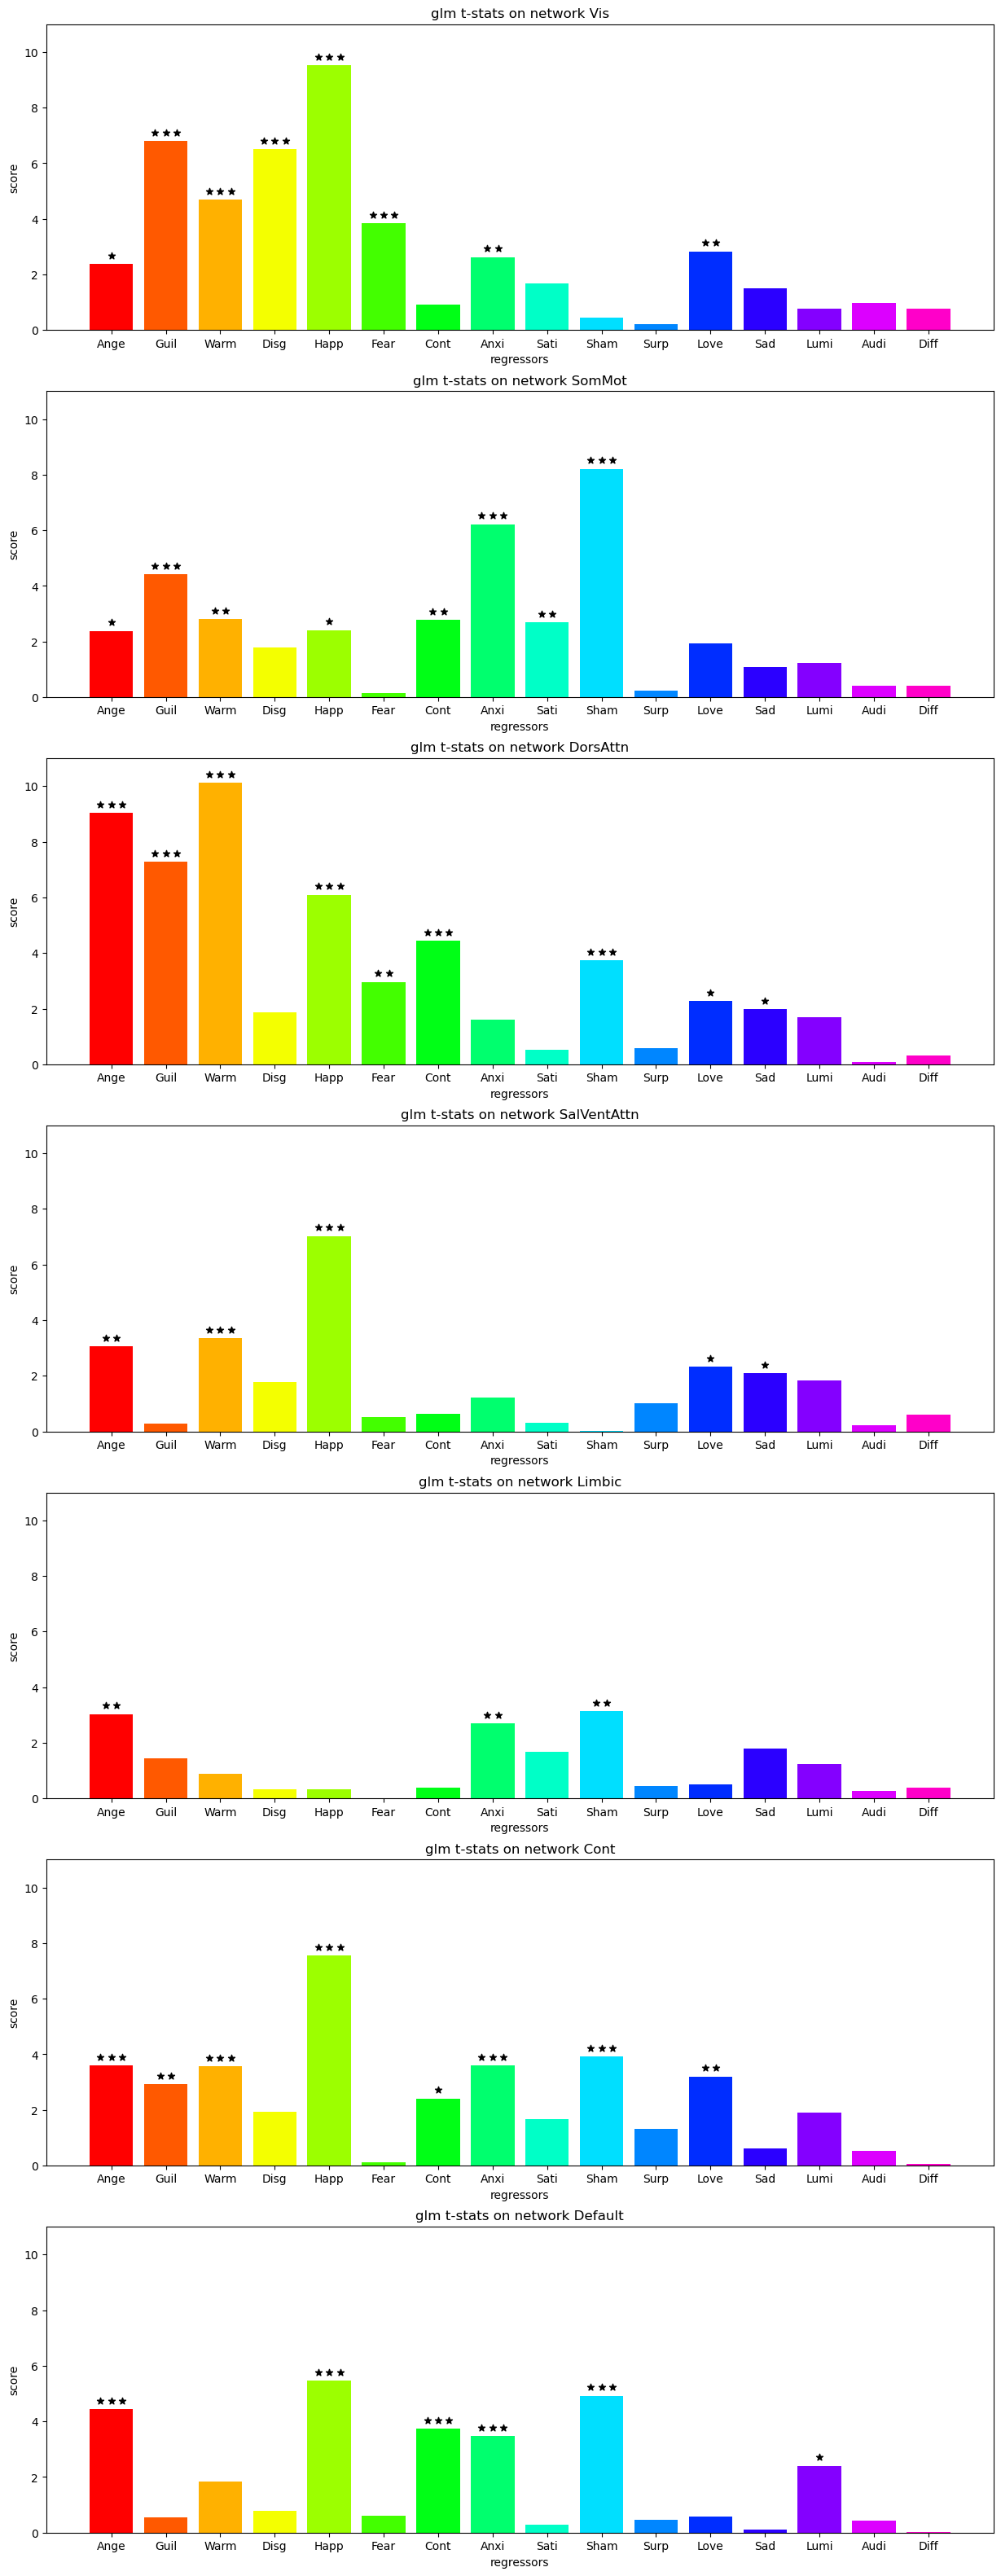

In [28]:
fig, ax = plt.subplots(len(networks),1, figsize=(15,40))

from matplotlib import cm
my_cmap = plt.cm.get_cmap('hsv')
colors = cm.hsv(np.arange(17) / float(17))


for k in range(len(networks)):
    cur_t,cur_p = glmnet[networks[k]]
    # remove intercept 
    cur_t = cur_t[1:]
    cur_p = cur_p[1:]

    # significancy display
    star_count = np.zeros_like(cur_p)
    star_count += cur_p < 0.05
    star_count += cur_p < 0.01
    star_count += cur_p < 0.001

    scatterx = []
    scattery = []
    for i in range(len(cur_t)):
        if star_count[i] == 1: 
            scatterx.append(i)
            scattery.append(np.abs(cur_t[i]) + 0.3)
        if star_count[i] == 2:
            scatterx.append(i-0.1)
            scatterx.append(i+0.1)
            scattery.append(np.abs(cur_t[i]) + 0.3)
            scattery.append(np.abs(cur_t[i]) + 0.3)
        if star_count[i] == 3:
            scatterx.append(i-0.2)
            scatterx.append(i)
            scatterx.append(i+0.2)
            scattery.append(np.abs(cur_t[i]) + 0.3)
            scattery.append(np.abs(cur_t[i]) + 0.3)
            scattery.append(np.abs(cur_t[i]) + 0.3)

    ax[k].scatter(scatterx, scattery, marker='*', linewidth=1, color='k')

    ax[k].bar(indexes, np.abs(cur_t), color=colors)
    ax[k].set_title("glm t-stats on network {}".format(networks[k]))
    ax[k].set_xlabel("regressors")
    ax[k].set_ylabel("score")
    ax[k].set_ylim(0,11)

In [11]:
grad_idx = 0
pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default")]

In [15]:
# PREPARING REGRESSORS
n, _ , _ = G_movie.shape
# window reason we resize by -1
n = n - 1 

regressors = [np.ones(n)]
smfactor = 1

for idx, pair in enumerate(tqdm(pairs)):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)
    regressors.append(z1[:n])
for idx, R in enumerate(networks):
    y  = network_variance(G_movie, R, grad_idx)
    z1 = zscore(y)
    regressors.append(z1[:n])
for idx, R in enumerate(networks):
    y  = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)
    regressors.append(z1[:n])
for idx, R in enumerate(networks):
    y  = varM[:,idx]
    z1 = zscore(y)
    regressors.append(z1[:n])
# regressors
regressors = np.stack(regressors)

100%|██████████| 7/7 [00:00<00:00, 36.18it/s]


In [123]:
table_t = {}
residuals = {}
for b in range(len(select)):
    emotion = select[b]
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
    smoothened = overlap_add(emo_series, smfactor)
    z2         = zscore(smoothened[:n])
    y = deepcopy(z2)

    # regress solving
    X = regressors.T

    beta = (np.linalg.inv(np.matmul(X.T, X)) @ X.T) @ y

    y_hat_meter = X @ beta

    N = y.size
    P = X.shape[1]
    df = (N - P)
    
    sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
    design_variance_weight = design_variance(X, 1)
    # print("Degrees of freedom: %i" % df)
    # print("Sigma-hat (noise) is: %.3f" % sigma_hat)
    residuals[emotion] = sigma_hat
    # t-stats
    t_meter = beta / np.sqrt(sigma_hat * design_variance_weight)

    # multiply by two to create a two-tailed p-value
    p_values = np.array([stats.t.sf(np.abs(t), df) * 2  for t in t_meter])

    table_t[emotion] = (t_meter,p_values)

In [127]:
regress_corr = np.zeros((28,28))
interest = regressors[1:]
for k in range(len(interest)):
    for j in range(len(interest)):
        regress_corr[k,j] = stats.pearsonr(interest[k], interest[j]).statistic


Text(0.5, 1.0, 'metrics correlation')

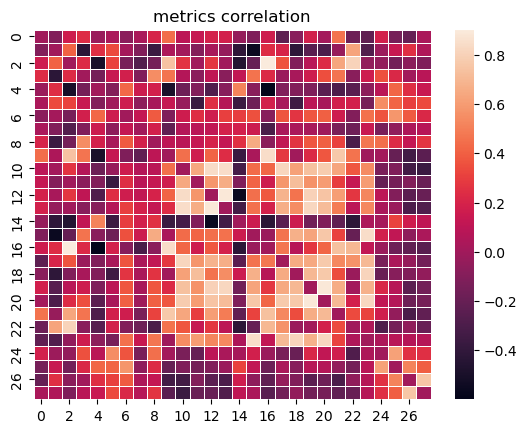

In [134]:
sns.heatmap(regress_corr - np.eye(28), linewidth=0.5)
plt.title("metrics correlation")

In [124]:
residuals

{'Anger': 0.1416022139409706,
 'Guilt': 0.12571483327544566,
 'WarmHeartedness': 0.22643851325411685,
 'Disgust': 0.2919396149545163,
 'Happiness': 0.16785623879285747,
 'Fear': 0.2052867580083054,
 'Contempt': 0.13734153317576434,
 'Anxiety': 0.26846556029730984,
 'Satisfaction': 0.18976013186639912,
 'Shame': 0.1441479825351459,
 'Surprise': 0.6471459842909474,
 'Love': 0.16350857163633598,
 'Sad': 0.13298153715117214}

In [119]:
arr1 = [p1+'_'+p2 for (p1,p2) in pairs]
arr2 = ["1d_var_{}".format(n) for n in networks]
arr3 = ["vol_{}".format(n) for n in networks]
arr4 = ["exp_var_{}".format(n) for n in range(len(networks))]
metrics_name = ['intercept'] + arr1 + arr2 + arr3 + arr4 

(0.0, 1.0, 0.0, 1.0)

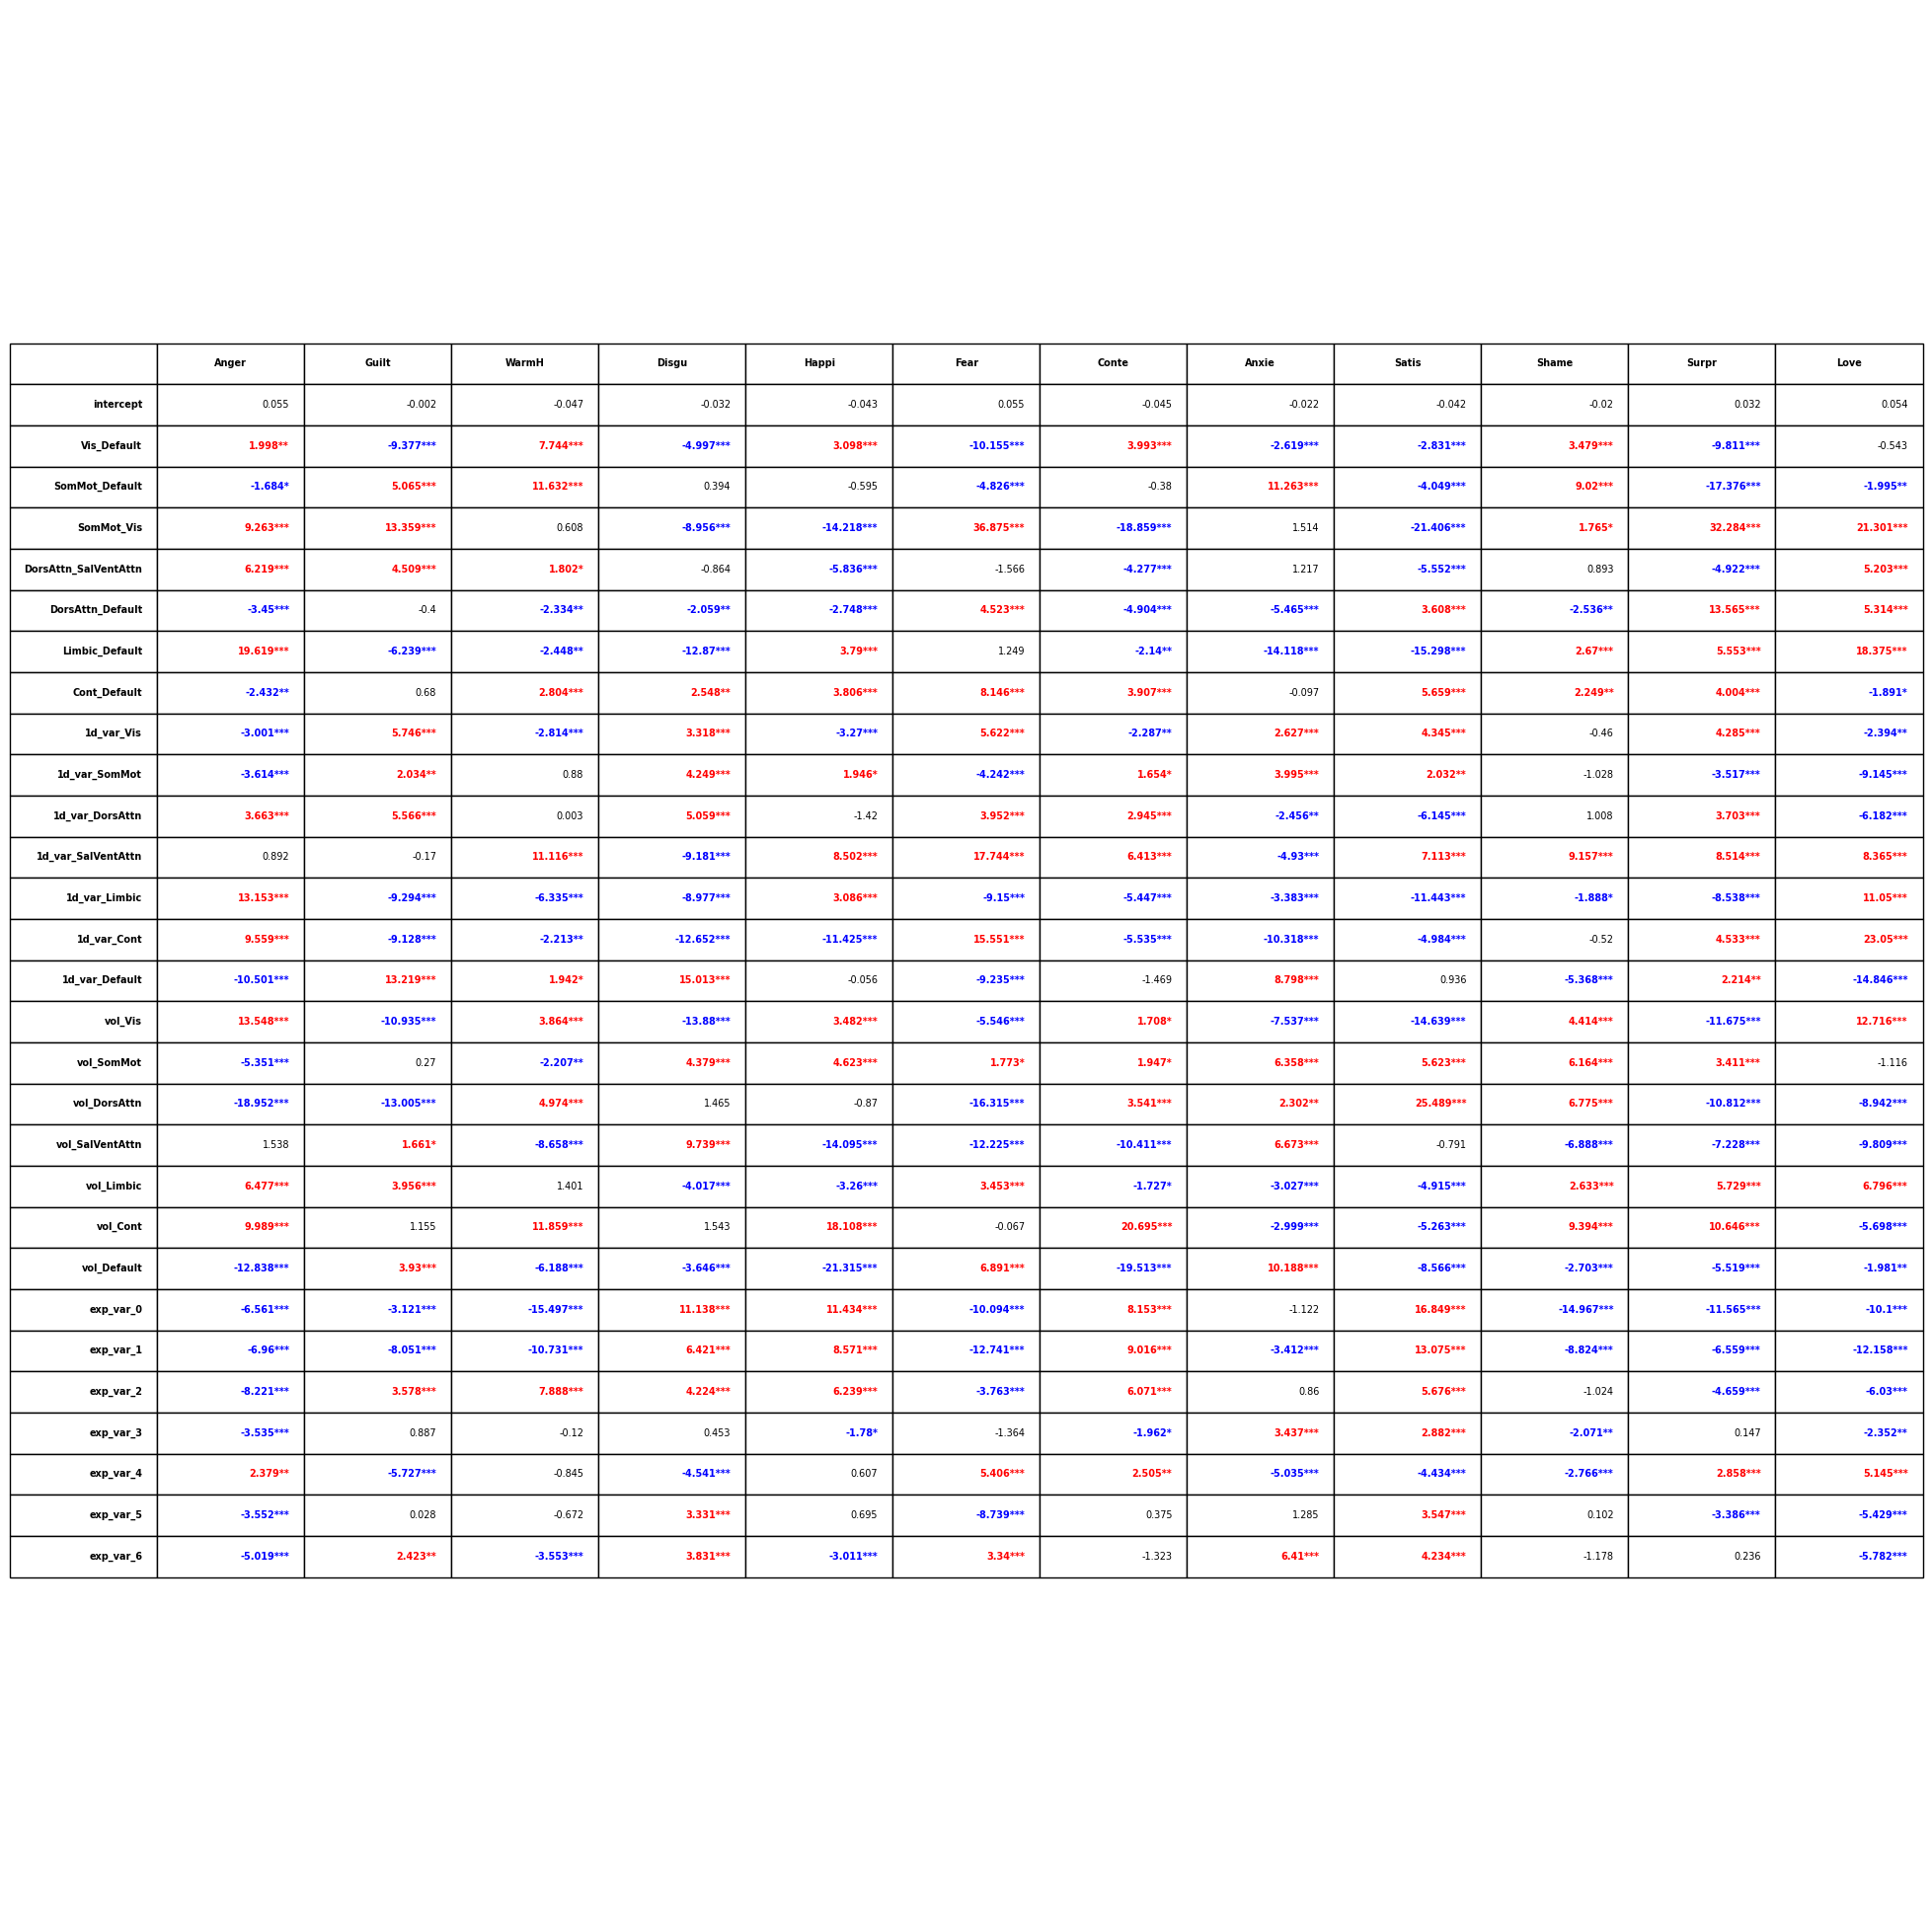

In [120]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(10,25))

tabling = np.empty((29,13), dtype=np.object_)
for j in range(13):
    for i in range(29):
        if j == 0:
            tabling[i,j] = metrics_name[i]
        else:
            emotion = select[j]
            tabling[i,j] = np.object_(np.round(table_t[emotion][0][i],3))


table = plt.table(cellText=tabling,
                        colLabels=[''] + [s[:5] for s in select],
                        loc='center')

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    if (col == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    
    emotion = select[col]
    
    # stress on which value is significant against null distribution
    nscore  = table_t[emotion][1][row-1]
    nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)
    
    if row != 0 and col !=0 :
        cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)
        
        if nbstars > 0:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            if float(tabling[row-1,col]) > 0:
                cell.get_text().set_color('red')
            else:
                cell.get_text().set_color('blue')

table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(2.5, 2.5)
plt.axis('off')

#### Visualization of correlation between metrics and actual movie with emotion series on the side
Details : Look at on correlation metric strong correlation, 2d joint plot moving over time (with some highlights) versus  movie emotions timeseries.
We choose here:
- Emotion : Anger
- Network : Dorsal Attention
- Metric  : Volume Change

In [3]:
# Compute Metric series
tmp_emo = 'Anger'
net     = 'DorsAttn'

ym  = np.asarray([network_volume(G_movie[t], net) 
                    for t in range(len(G_movie))])

# Find Emotion series
emo_series = np.array(emo_df[emo_df.item==tmp_emo]['score'])
smoothened = overlap_add(emo_series, 1)
ye   = zscore(smoothened[:ym.shape[0]])

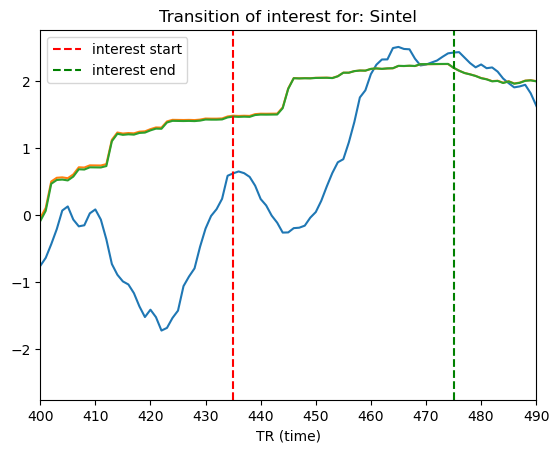

In [4]:
# We want to extract a quick snippet of emotion/metric and watch the corresponding video snippet
plt.plot(zscore(-ym))
# plt.plot(-ym)
plt.plot(ye)
plt.plot(zscore(smoothened))
plt.xlim(400,490)
plt.title('Transition of interest for: {}'.format(moviename))
plt.xlabel('TR (time)')
# We select our snippet to be showing 1 sharp transition, i.e from TR 220 to TR 235 which would give us 15 * TR seconds of movies
moviestart = TR * 435
movieend   = TR * 475
plt.axvline(x=435, linestyle='--', label='interest start', color='r')
plt.axvline(x=475, linestyle='--', label='interest end', color='g')
plt.legend()

In [6]:
fps = 24
start_idx = int(moviestart * fps)
end_idx   = int(movieend * fps)

frames = video2img('./zeal/Sintel_zeal_Surprise.mp4', start_idx=start_idx, end_idx=end_idx)

Display FPS is: 24.0


In [5]:
import moviepy.editor as mp

In [6]:
my_clip = mp.VideoFileClip(r"./zeal/Sintel_zeal_Surprise.mp4")
myclip.audio.write_audiofile("/tmp/data/test.wav",codec='pcm_s16le')

In [7]:
tmp_clip = my_clip.subclip(moviestart, movieend)

In [9]:
tmp_clip.audio.write_audiofile("./audio.wav", codec="pcm_s32le")

chunk:   3%|▎         | 37/1147 [00:47<23:56,  1.29s/it, now=None]

MoviePy - Writing audio in ./audio.wav


chunk:   3%|▎         | 37/1147 [00:48<24:12,  1.31s/it, now=None]

MoviePy - Done.


Text(0, 0.5, 'G2')

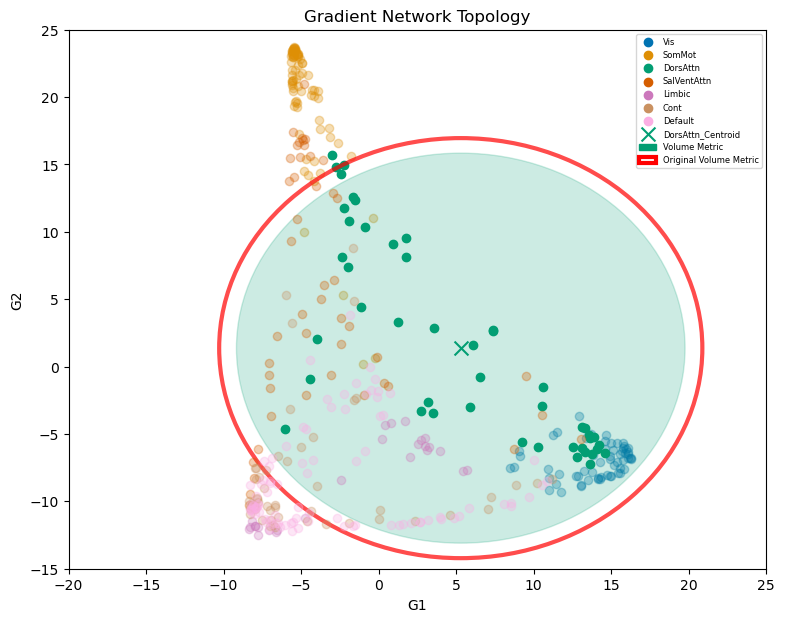

In [14]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
frame  = 100
fig,ax = plt.subplots(figsize=(9,7))
for idx,net in enumerate(networks):

    if net == 'DorsAttn':
        ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
        color=my_cmap.colors[idx], alpha=1, label=net)

        C1 = G_movie[frame,index2region[net],0].mean()
        C2 = G_movie[frame,index2region[net],1].mean()
        ax.scatter(C1, C2, marker='x', s=100,
        color=my_cmap.colors[idx], alpha=1, label=net + '_Centroid')

        R = network_volume(G_movie[frame][:,:2], net)
        circle = plt.Circle((C1, C2), R, color=my_cmap.colors[idx], alpha=0.2, label='Volume Metric')
        ax.add_patch(circle)

        # adding metric circle from the first frame to give a sense of change
        R = network_volume(G_movie[0][:,:2], net)        
        circle = plt.Circle((C1, C2), R, color='r', alpha=0.7, label='Original Volume Metric', fill=False, linewidth = 3)
        ax.add_patch(circle)
    else:
        ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
        color=my_cmap.colors[idx], alpha=0.3, label=net)        


handles, labels = ax.get_legend_handles_labels()
order  = [0,1,2,6,7,8,9,3,4,5]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=1, prop={'size':6})
for lh in legend.legendHandles: 
    lh.set_alpha(1)
ax.set_title("Gradient Network Topology")
ax.set_xlim(-20,25)
ax.set_ylim(-15,25)
ax.set_xlabel('G1', fontsize=10)
ax.set_ylabel('G2', fontsize=10)

In [17]:
# Generate the corresponding joint plot video
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
for j in tqdm(range(len(G_movie))):
    frame  = j
    fig,ax = plt.subplots(figsize=(9,7))
    for idx,net in enumerate(networks):
        if net == 'DorsAttn':
            ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
            color=my_cmap.colors[idx], alpha=1, label=net)

            C1 = G_movie[frame,index2region[net],0].mean()
            C2 = G_movie[frame,index2region[net],1].mean()
            ax.scatter(C1, C2, marker='x', s=100,
            color=my_cmap.colors[idx], alpha=1, label=net + '_Centroid')

            R = network_volume(G_movie[frame][:,:2], net)
            circle = plt.Circle((C1, C2), R, color=my_cmap.colors[idx], alpha=0.2, label='Volume Metric')
            ax.add_patch(circle)

            # adding metric circle from the first frame to give a sense of change
            R = network_volume(G_movie[435][:,:2], net)        
            circle = plt.Circle((C1, C2), R, color='r', alpha=0.7, label='Original Volume Metric', fill=False, linewidth = 3)
            ax.add_patch(circle)            
        else:
            ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
            color=my_cmap.colors[idx], alpha=0.3, label=net)

            
    handles, labels = ax.get_legend_handles_labels()
    order  = [0,1,2,6,7,8,9,3,4,5]
    legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=1, prop={'size':8})
    for lh in legend.legendHandles: 
        lh.set_alpha(1)
    ax.set_title("Gradient Network Topology")
    ax.set_xlim(-20,25)
    ax.set_ylim(-15,25)
    ax.set_xlabel('G1', fontsize=10)
    ax.set_ylabel('G2', fontsize=10)
    fig.savefig("./media/gradient_plots/{}_{}.jpg".format(moviename,j))
    plt.close("all")

100%|██████████| 516/516 [00:58<00:00,  8.81it/s]


In [18]:
path = "./media/gradient_plots/"

# reorder saved images path
movie_path  = loadimg_in_order([m for m in os.listdir(path)])
movie_array = [cv2.imread(path+'/'+filename) for filename in movie_path]

img2video(movie_array, 10, outpath_name='./media/{}_attention_ws{}.mp4'.format(moviename,40))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [8]:
# Let's combine the images
nbdup = len(frames)//40
images = []
for i in range(435,475):
    path = './media/gradient_plots/{}_{}.jpg'.format(moviename, i)
    for _ in range(nbdup):
        images.append(cv2.imread(path))

In [9]:
images = np.asarray(images)
frames = np.asarray(frames)

In [10]:
padimages = np.asarray([ cv2.resize(images[i] ,(800,544))[:,:,::-1] for i in range(len(images))])

In [11]:
merged = compare_videos(frames[:,:,:,::-1], padimages)

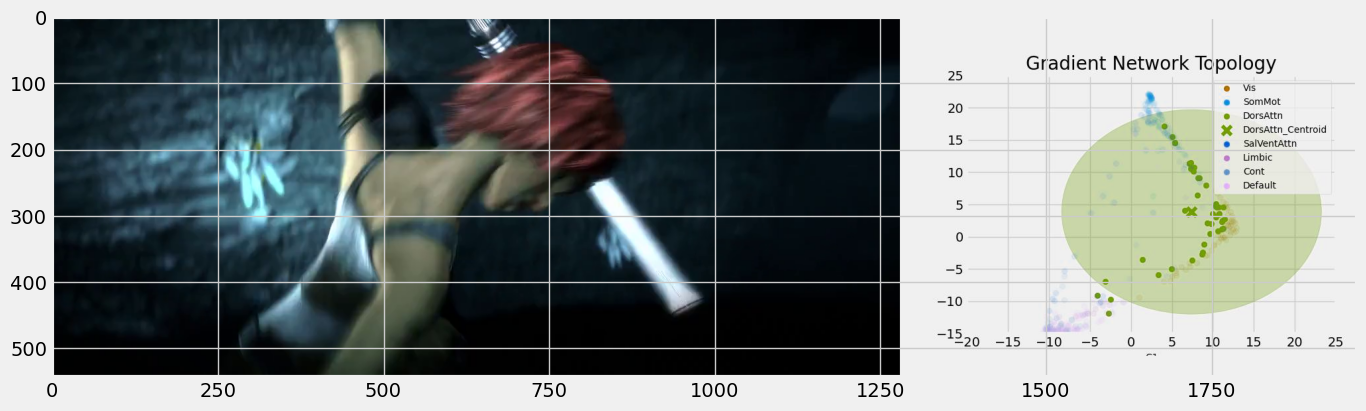

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(merged[0])

In [12]:
img2video(merged[:,:,:,::-1], 24, '24fps.mp4')
# img2video(merged[:,:,:,::-1], 72,' 72fps.mp4')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


: 

In [51]:
#### Permutation Testing


# idxa = 5
# idxb = 11

# other_df = full_df[full_df.filename != 'W_Sintel13.csv']
# order2 = list(other_df.filename.unique())
# np.random.shuffle(order2)

# concat_other  = np.array(other_df[other_df.item == select[idxb]]['score'])
# concat_other2 = np.concatenate([other_df[(other_df.item == select[idxb]) & 
#                             (other_df.filename == o)].score for o in order2])

# # Obtained sample correlation
# a = np.abs(G_movie[:,index2region[networks[idxa]]]).std(axis=1)[:,grad_idx]
# b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
# b = overlap_add(b, 1)
# cur,_,_ = correlation_search(zscore(a), zscore(b[:len(a)]), 0, 1)

# discrete = []
# for o in order2:
#     f = other_df[(other_df.item == select[idxb]) & (other_df.filename == o)].score
#     f = overlap_add(f, 1)
#     m = min(len(f), len(a))
#     corr,_,_ = correlation_search(zscore(a)[:m], zscore(f[:m]), 0, 1)
#     discrete.append(corr)


# # from mlxtend.evaluate import permutation_test
# # permutation_test(a , c, method='approximate', num_rounds=10000, func=lambda x,y: np.corrcoef(x,y)[1][0], seed=0)

# # another order of emotions series
# null_distrib3 = []
# for i in range(len(concat_other2) - len(a)):
#     e = concat_other2[i:i+len(a)]
#     e = overlap_add(e, 1)
#     a, e = zscore(a), zscore(e)
#     corr, _,_ = correlation_search(a,e, 0, 1)
#     null_distrib3.append(corr)

# # default order of emotions series
# null_distrib2 = []
# for i in range(len(concat_other) - len(a)):
#     d = concat_other[i:i+len(a)]
#     d = overlap_add(d, 1)
#     a, d = zscore(a), zscore(d)
#     corr, _,_ = correlation_search(a,d, 0, 1)
#     null_distrib2.append(corr)

# # shuffling gradient metrics series
# np.random.seed(10)
# nb_shuffle = 10000
# samples = np.zeros((nb_shuffle, len(a)))
# for i in range(nb_shuffle):
#     ashuffle = deepcopy(a)
#     np.random.shuffle(ashuffle)
#     samples[i] = ashuffle

# c = b[:a.shape[0]]

# null_distrib = []
# for i in range(len(samples)):
#     null_distrib.append(correlation_search(samples[i], c, 0, 1)[0])


# plt.hist(null_distrib, bins=100, alpha=0.7, label="shuffle gradient metrics timeseries")
# plt.hist(null_distrib2, bins=100, alpha=0.7, label="parse concat emotion timeseries order1")
# plt.hist(null_distrib3, bins=100, alpha=0.7, label="parse concat emotion timeseries order2")
# plt.axvline(x=cur, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
# for k in range(len(discrete)):
#     plt.axvline(x=discrete[k], c='g', linestyle='dotted', linewidth=2)
# plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
# plt.legend(loc=1, prop={'size':8})